# Group Members
Anthony Marcozzi
Haggin Hubert
Claire Gilder

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Mixture Models

## Sampling from a GMM
A Gaussian Mixture Model is a distribution over real valued features
$$
P(\mathbf{x}) = \sum_{k=1}^N \pi_k \mathcal{N}(\mathbf{x};\mu_k,\Sigma_k).
$$
where $N$ is the number of mixture elements.  To visualize this distribution, let's create a method to draw samples from it using a technique called 'ancestral sampling.'  To do this, we first need to draw a latent variable $\mathbf{z}$ from the categorical distribution
$$
P(\mathbf{z}) = \mathrm{Cat}(\mathbf{z}; \mathbf{\pi}).
$$
where $\mathbf{z}$ is a one-hot vector, and $\mathbf{\pi}$ is the vector describing the probability of choosing the $k$-th mixture element.  Then we simply generate a random sample from the corresponding normal distribution:
$$P(\mathbf{x}|\mathbf{z}_k) = \mathcal{N}(\mathbf{x};\mu_k,\Sigma_k).$$

**Implement a method that performs this random sampling, and produces a scatter plot.  You should see 3 different clusters of points emerge, each with their own mean and covariance structure**.  This is not explicitly needed for fitting a GMM, but it is helpful for understanding what data from this sort of model looks like and what its parameters are.

*An important thing to consider is how to store the parameters of this model.  For example, we have $N$ values of $\pi$, $N$ values of $\mu$ (which is a vector), and $N$ values of $\Sigma$ (which is a matrix).  I stored the values of $\mathbf{\pi}$ as a vector, those of $\mu$ as an $N \times n$ array, and the values of $\Sigma$ as an $N \times n \times n$ tensor.*    

In [2]:
n = 2
N = 3

pi = np.ones(N)
pi /= pi.sum()
Sigmas = np.array([[[ 0.00077286, -0.00064568],
               [-0.00064568,  0.01741133]],

              [[ 0.01613111, -0.0089063 ],
               [-0.0089063 ,  0.01046741]],

              [[ 0.00614272,  0.00158026],
               [ 0.00158026,  0.00947669]]])

mus = np.array([[ 0.83279303, -0.34147297],
                [ 0.16370222, -0.1546724 ],
                [-0.17638307, -1.07478137]])
print(f'pi has shape {pi.shape}')
print(f'Sigma has shape {Sigmas.shape}')
print(f'mus has shape {mus.shape}')

pi has shape (3,)
Sigma has shape (3, 2, 2)
mus has shape (3, 2)


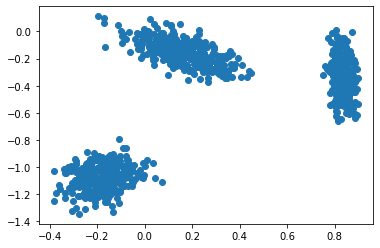

In [3]:
def sample_z(pi):
    random_vec = np.random.multinomial(1000, pi)
    one_hot = random_vec // random_vec.max()
    return one_hot 

def sample_x_given_z(mu,Sigma,z_vec):
    z_idx = z.argmax()
    mu_vec = mu[z_idx, :]
    sigma_arr = Sigma[z_idx, :, :]
    L = np.linalg.cholesky(sigma_arr)
    q = np.random.normal(size=n)
    x = mu_vec + L @ q
    return x 

n_samples = 1000
x_samples = np.zeros((n_samples,n))

for i in range(n_samples):
    # Compute samples and fill in
    z = sample_z(pi)
    x = sample_x_given_z(mus,Sigmas,z)
    x_samples[i] = x
    
plt.scatter(x_samples[:,0],x_samples[:,1])   
plt.show()

## Fitting a GMM

Now that we understand how these things are parameterized, let's fit one to some data using expectation maximization.  First, we need a dataset.  One useful one for this purpose is called the Old Faithful dataset.  It contains two features regarding the famous geyser: eruption interval and eruption length.  Normalizing in the usual way, we have    

272 2


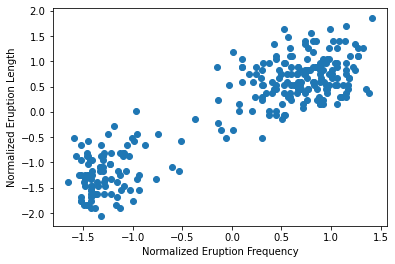

In [7]:
X = np.loadtxt('faithful.dat',skiprows=26,usecols=[1,2])
X -= X.mean(axis=0)
X /= X.std(axis=0)

m,n = X.shape
print(m, n)

plt.scatter(X[:,0],X[:,1])
plt.xlabel("Normalized Eruption Frequency")
plt.ylabel("Normalized Eruption Length")
plt.show()

We'll try to fit a GMM to this dataset.  First, we need to select the hyperparameter $N$: the number of mixture components.  This is easy to do for this dataset, but we'll also consider how to select this parameter using BIC in a moment.  **Select and store a value for N**.

In [8]:
N = 2 # CHANGE ME

Now, instantiate some random initial values for the $N$ instances of $\pi$, $\mu$, and $\Sigma$.  

*Hint 1: the $N$ entries in $\pi$ need to sum to unity.  Hint 2: each of the $N$ $\Sigma$'s needs to be a valid covariance matrix, which is to say symmetric and positive definite. If you don't know what that means, it's okay: an adequate solution is to initialize $\Sigma_k = I$ for all $k$.  It's also possible to initialize $\Sigma_k$ randomly by generating a random matrix $A_k$, and then computing $\Sigma_k = A_k^T A_k$. *

In [106]:
def initialize_params(N):
    pi = np.ones(N)#np.random.rand(N)
    pi/=pi.sum()
    mu = np.random.randn(N,n)
    A = np.concatenate([np.eye(n)[None,:,:] for i in range(N)],axis=0)#np.random.randn(N,n,n)
    Sigma = np.einsum('...ij,...kj',A,A)
    return mu,Sigma,pi

mu,Sigma,pi = initialize_params(N)
# print(f'{mu}, {mu.shape}')
# print(f'{Sigma}, {Sigma.shape}')
# print(f'{pi}, {pi.shape}')
print(Sigma[0, :, :])

[[1. 0.]
 [0. 1.]]


We can plot the associated normal distributions on top of the data plot above using the following matpotlib commands. (note that this doesn't involve $\pi$).

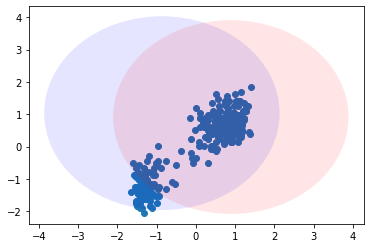

In [10]:
from matplotlib.patches import Ellipse  
def cov_ellipse(mu_k, Sigma_k, ax, color):
    # Plots the 3-sigma credible countour for a given multivariate normal distribution.  
    
    # How does this work?  (think about PCA).
    w,v = np.linalg.eig(Sigma_k)
    ellipse = Ellipse(mu_k, width=3*np.sqrt(w[0]) * 2, height=3*np.sqrt(w[1]) * 2, angle=np.rad2deg(np.arccos(v[0,0])),alpha=0.1, facecolor=color)
    return ax.add_patch(ellipse)

fig,ax = plt.subplots()
ax.scatter(X[:,0],X[:,1])
colors=['blue', 'red']
for k in range(N):
    color = colors[k]
    cov_ellipse(mu[k],Sigma[k],ax, color)

As expected, the randomly initialized fit is poor.  Let's use expectation maximization to improve this.  EM works by alternating between A) estimating which mixture component a data point 'belongs to' and B) recomputing the parameters of the mixture components based on those memberships.  

First, **implement a function that estimates the expected value of the component membership given your $N$ sets of normal distribution parameters**.  The formula for this is 
$$
P(\mathbf{z}|\mathbf{x}) = E[\mathbf{z}] = \frac{\mathcal{N}(\mathbf{x};\mu_k,\Sigma_k) \pi_k}{\sum_{j=1}^N \mathbf{x};\mu_j,\Sigma_j) \pi_j}
$$
*Note 1: this function should accept a batch of data.  I've done most of the hard work for you already by implementing a function that evaluates the probability density function for a multivariate normal on a batch of observed $X$s.  Before you begin to implement this thing, decide what you think the output shape should be!*

*Note 2: you may wish to devise some sort of plot to ensure that your method is working correctly.  For example, you could create a scatter plot, with points colored by probability of membership in one of the clusters.*


In [13]:
def mvnormal_pdf(X,mu_k,Sigma_k):
    n = mu_k.shape[0]
    exp_term = np.exp(-0.5*np.einsum('ij,ji->i', X-mu_k,np.linalg.solve(Sigma_k,(X-mu_k).T)))
    return (2*np.pi)**(-n/2)*np.linalg.det(Sigma_k)**(-0.5)*exp_term

def expected_class(X,mu,Sigma,pi):
    # Compute each multivariate normal distribution
    normals = np.zeros([2, X.shape[0]])
    for j in range(N):
        normals[j, :] = mvnormal_pdf(X, mu[j, :], Sigma[j, :, :]) * pi[j]
    denominator = normals.sum(axis=0)
    Ez = normals / denominator
    return Ez

ec = expected_class(X, mu, Sigma, pi)

Second, let's do the maximization step, where we compute the maximum likelihood estimators for all of the $\pi$, $\Sigma$, and $\mu$ values.  The estimators are
$$
N_k = \sum_{i=1}^m E[\mathbf{z}_k]
$$
$$
\mu_k^{new} = \frac{1}{N_k} \sum_{i=1}^m E[\mathbf{z}_k]_i \mathbf{x}_{i}
$$
$$
\Sigma_k^{new} = \frac{1}{N_k} \sum_{i=1}^m E[\mathbf{z}_k]_i (\mathbf{x}_i - \mu_k^{new})(\mathbf{x}_i - \mu_k^{new})^T
$$
**Implement these estimators**.  One of the tricky parts of this is getting all of the indices and shapes correct.  Think carefully about what you expect the shapes of these things to be, and how to store them in clean way.  


In [143]:
def estimate_params(X,Ez, num_classes):
    N_return = np.zeros(2)
    mu_new = np.zeros([2, 2])
    Sigma_new = np.zeros([2, 2, 2])
    for k in range(num_classes):
        # Compute N_k new
        N_k = Ez[k, :].sum()
        N_return[k] = N_k
        
        # compite mu_k new
        sum_result = 0
        mu_k_new = (1 / N_k) * (Ez[k, :] @ X)
        mu_new[k, :] = mu_k_new
        
        # Compute sigma_k new
        sum_result = 0
        for i in range(X.shape[0]):
            diff = (X[i, :] - mu_k_new).reshape(-1, 1)
            term = diff @ diff.T
            sum_result += Ez[k, i] * term
        sigma_k_new = sum_result / N_k
        # Sigma_new[k, :, :] = np.array([[sigma_k_new[0], sigma_k_new[1]], [sigma_k_new[1], sigma_k_new[0]]])
        Sigma_new[k, :, :] = sigma_k_new
        
    # Compute pi_new
    pi_new = np.zeros(2)
    for k in range(num_classes):
        pi_new[k] = N_return[k] / np.sum(N_return)
        
    return mu_new,Sigma_new,pi_new

mu_test, Sigma_test, pi_test = estimate_params(X, ec, N)
print(Sigma_test[0, :, :])

[[0.81483909 0.77470882]
 [0.77470882 0.92505309]]


# With both expectation and maximization steps defined, we can do EM.  **Create a function that iteratively perform the expectation and maximization steps.**  Convergence should be achieved very quickly (no more than 25 iterations should yield a very good fit to the data, although you may find pathalogical initial conditions.  Plot the resulting normal distributions (or their covariance ellipses) atop the data.  

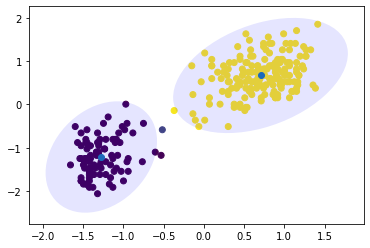

In [146]:
def expectation_maximization(X,N=2):
    mu,Sigma,pi = initialize_params(N)
    Ez = expected_class(X, mu, Sigma, pi)
    for i in range(25):
        mu, Sigma, pi = estimate_params(X, Ez, N)
        # print(mu, Sigma[0, :, :], Sigma[1, :, :], pi)
        Ez = expected_class(X, mu, Sigma, pi)
        # print(Ez)
    return Ez,mu,Sigma,pi

Ez,mu,Sigma,pi = expectation_maximization(X,N=N)

fig,ax = plt.subplots()
k = 0
c = ax.scatter(X[:,0],X[:,1],c=Ez[k,:])
plt.scatter(mu[:,0],mu[:,1])
for k in range(N):
    cov_ellipse(mu[k],Sigma[k],ax,color='blue')

## Model selection
While it is easier to see the appropriate number of clusters for this dataset, that's not always going to be true.  To select between models, we can choose the model that maximizes the Bayesian information criterion, which is approximately proportional to the log-evidence:
$$
P(X|N) \approx \mathrm{BIC} = 2\mathcal{L}(X;N,\hat{\theta}_N) - |\theta_k| \ln{m},
$$
where $|\theta_k|$ means the number of free-parameters associated with the model for a given $N$, and $\hat{\theta}$ is the maximum likelihood estimators for $\theta_N$.  It provides an approximate metric for how likely a given model (varied in terms of $N$) fits the data marginalized over all parameter values.  Here's an implementation:

In [52]:
def bic(X,N):
    Ez,mu,Sigma,pi = expectation_maximization(X,N=N) # You might need to change this 
    log_like = np.sum(np.log((np.vstack([mvnormal_pdf(X,m,S) for m,S in zip(mu,Sigma)]).T*pi[None,:]).sum(axis=1)))
    num_params = mu.size + 0.5*np.sqrt(Sigma.size)*(np.sqrt(Sigma.size)+1) + pi.size
    return 2*log_like - num_params*np.log(m)


Compute and plot the BIC for a range of $N$ values (for example, between 1 and 8).  What's an appropriate number of clusters for this problem?

In [ ]:
# Compute and plot BICs for a range of N values here